In [ ]:
# https://sebastianraschka.com/Articles/2014_sqlite_in_python_tutorial.html
    
# https://datacarpentry.org/python-ecology-lesson/09-working-with-sql/index.html
    
# https://stackoverflow.com/questions/43029554/csv-insert-per-line-to-mysql-python

In [1]:
#!pip install cufflinks
#!pip install pyshp
#!pip install descartes
#!pip install SQLAlchemy

In [2]:
import pandas as pd
import numpy as np
import urllib.request
import zipfile
import random
import itertools
import math
import folium

import shapefile
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [3]:
from sqlalchemy import create_engine

nyc_database = create_engine('sqlite:///nyc_database.db')

In [3]:
# Download the Trip Record Data
for month in range(1,2):
    urllib.request.urlretrieve("https://s3.amazonaws.com/nyc-tlc/trip+data/"+ \
                               "yellow_tripdata_2019-{0:0=2d}.csv".format(month), 
                               "data/nyc_2019-{0:0=2d}.csv".format(month))
# Download the location Data
# urllib.request.urlretrieve("https://s3.amazonaws.com/nyc-tlc/misc/taxi_zones.zip", "taxi_zones.zip")
# with zipfile.ZipFile("taxi_zones.zip","r") as zip_ref:
#     zip_ref.extractall("./data/shape")

In [4]:
df = pd.read_csv("data/nyc_2019-01.csv", nrows=10)
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2019-01-01 00:46:40,2019-01-01 00:53:20,1,1.5,1,N,151,239,1,7.0,0.5,0.5,1.65,0.0,0.3,9.95,NaN
1,1,2019-01-01 00:59:47,2019-01-01 01:18:59,1,2.6,1,N,239,246,1,14.0,0.5,0.5,1.00,0.0,0.3,16.30,NaN
2,2,2018-12-21 13:48:30,2018-12-21 13:52:40,3,0.0,1,N,236,236,1,4.5,0.5,0.5,0.00,0.0,0.3,5.80,NaN
3,2,2018-11-28 15:52:25,2018-11-28 15:55:45,5,0.0,1,N,193,193,2,3.5,0.5,0.5,0.00,0.0,0.3,7.55,NaN
4,2,2018-11-28 15:56:57,2018-11-28 15:58:33,5,0.0,2,N,193,193,2,52.0,0.0,0.5,0.00,0.0,0.3,55.55,NaN


In [ ]:
j, chunksize = 1, 100000
for month in range(1,2):
    fp = "data/nyc_2019-{0:0=2d}.csv".format(month)
    for df in pd.read_csv(fp, chunksize=chunksize, iterator=True):
        df = df.rename(columns={c: c.replace(' ', '_') for c in df.columns})
        df['pickup_hour'] = [x[11:13] for x in df['tpep_pickup_datetime']]
        df['dropoff_hour'] = [x[11:13] for x in df['tpep_dropoff_datetime']]
        df.index += j
        df.to_sql('nyc_2019-'+str(month), nyc_database, if_exists='append')
        j = df.index[-1] + 1
del df

In [10]:
sf = shapefile.Reader("data/shape/taxi_zones.shp")
sf.fields

[('DeletionFlag', 'C', 1, 0),
 ['OBJECTID', 'N', 9, 0],
 ['Shape_Leng', 'F', 19, 11],
 ['Shape_Area', 'F', 19, 11],
 ['zone', 'C', 254, 0],
 ['LocationID', 'N', 4, 0],
 ['borough', 'C', 254, 0]]

In [11]:
fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
shp_dic

{'OBJECTID': 0,
 'Shape_Leng': 1,
 'Shape_Area': 2,
 'zone': 3,
 'LocationID': 4,
 'borough': 5}

In [12]:
sf.records()

[Record #0: [1, 0.116357453189, 0.0007823067885, 'Newark Airport', 1, 'EWR'],
 Record #1: [2, 0.43346966679, 0.00486634037837, 'Jamaica Bay', 2, 'Queens'],
 Record #2: [3, 0.0843411059012, 0.000314414156821, 'Allerton/Pelham Gardens', 3, 'Bronx'],
 Record #3: [4, 0.0435665270921, 0.000111871946192, 'Alphabet City', 4, 'Manhattan'],
 Record #4: [5, 0.0921464898574, 0.000497957489363, 'Arden Heights', 5, 'Staten Island'],
 Record #5: [6, 0.150490542523, 0.000606460984581, 'Arrochar/Fort Wadsworth', 6, 'Staten Island'],
 Record #6: [7, 0.107417171123, 0.000389787989274, 'Astoria', 7, 'Queens'],
 Record #7: [8, 0.0275906911574, 2.6587716279e-05, 'Astoria Park', 8, 'Queens'],
 Record #8: [9, 0.0997840924705, 0.000338443803197, 'Auburndale', 9, 'Queens'],
 Record #9: [10, 0.0998394794152, 0.000435823818081, 'Baisley Park', 10, 'Queens'],
 Record #10: [11, 0.0792110389596, 0.00026452053504, 'Bath Beach', 11, 'Brooklyn'],
 Record #11: [12, 0.0366613013579, 4.15116236727e-05, 'Battery Park', 12

In [ ]:
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

In [13]:
sf = shapefile.Reader("data/shape/taxi_zones.shp")
fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

df_shp = pd.DataFrame(shp_attr)
df_shp.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough
0,1,0.116357,0.000782,Newark Airport,1,EWR
1,2,0.433470,0.004866,Jamaica Bay,2,Queens
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx
3,4,0.043567,0.000112,Alphabet City,4,Manhattan
4,5,0.092146,0.000498,Arden Heights,5,Staten Island


In [15]:
import geopandas as gpd
latlong_df = gpd.read_file('data/NY-Places.geojson')
latlong_df = latlong_df[["Id", "geometry"]]
latlong_df

,Id,geometry
0,90,POINT (-73.88896 40.89621)
1,95,POINT (-73.87165 40.88988)
2,81,POINT (-73.83864 40.88697)
3,69,POINT (-73.80980 40.87799)
4,8,POINT (-73.87831 40.86442)
...,...,...
91,75,POINT (-73.91683 40.89231)
92,86,POINT (-73.86497 40.65914)
93,97,POINT (-74.00743 40.72660)
94,96,POINT (-73.96628 40.70052)


In [23]:
df_loc = pd.merge(df_shp, latlong_df, left_on='LocationID', right_on='Id')
df_loc

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,Id,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,1,POINT (-73.74427 40.75366)
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,2,POINT (-73.83062 40.67219)
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,3,POINT (-73.92427 40.77679)
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,4,POINT (-73.78692 40.67325)
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,5,POINT (-73.85499 40.67729)
...,...,...,...,...,...,...,...,...
91,95,0.113630,0.000573,Forest Hills,95,Queens,95,POINT (-73.87165 40.88988)
92,96,0.185180,0.000548,Forest Park/Highland Park,96,Queens,96,POINT (-73.87524 40.84901)
93,96,0.185180,0.000548,Forest Park/Highland Park,96,Queens,96,POINT (-73.96628 40.70052)
94,96,0.185180,0.000548,Forest Park/Highland Park,96,Queens,96,POINT (-73.93440 40.55099)


In [24]:
def draw_region_map(ax, sf, heat={}):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)    
    
    reg_list={'Staten Island':1, 'Queens':2, 'Bronx':3, 'Manhattan':4, 'EWR':5, 'Brooklyn':6}
    reg_x = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'EWR':[], 'Brooklyn':[]}
    reg_y = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'EWR':[], 'Brooklyn':[]}
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=math.sqrt(min(heat.values())), vmax=math.sqrt(max(heat.values()))) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
        cm=plt.get_cmap('Reds')
        #sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        #sm.set_array([])
        #plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8), \
        #             boundaries=np.arange(min(heat.values())-10,max(heat.values())+10,.1))
    
    ax.set_facecolor(ocean)
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        reg_name = rec[shp_dic['borough']]
        
        if len(heat) == 0:
            norm = mpl.colors.Normalize(vmin=1,vmax=6) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
            cm=plt.get_cmap('Pastel1')
            R,G,B,A = cm(norm(reg_list[reg_name]))
            col = [R,G,B]
        else:
            R,G,B,A = cm(norm(math.sqrt(heat[reg_name])))
            col = [R,G,B]
            
        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
                
        reg_x[reg_name].append((shape.bbox[0]+shape.bbox[2])/2)
        reg_y[reg_name].append((shape.bbox[1]+shape.bbox[3])/2)
        
    for k in reg_list:
        if len(heat)==0:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), k, horizontalalignment='center', verticalalignment='center',
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)     
        else:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), "{}\n({}K)".format(k, heat[k]/1000), horizontalalignment='center', 
                     verticalalignment='center',bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)       

    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])

In [25]:
def get_boundaries(sf):
    lat, lon = [], []
    for shape in list(sf.iterShapes()):
        lat.extend([shape.bbox[0], shape.bbox[2]])
        lon.extend([shape.bbox[1], shape.bbox[3]])

    margin = 0.01 # buffer to add to the range
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin

    return lat_min, lat_max, lon_min, lon_max

In [27]:
def draw_zone_map(ax, sf, heat={}, text=[], arrows=[]):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)
    theta = np.linspace(0, 2*np.pi, len(text)+1).tolist()
    ax.set_facecolor(ocean)
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=min(heat.values()),vmax=max(heat.values())) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
        cm=plt.get_cmap('Reds')
        sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        sm.set_array([])
        plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8),
                     boundaries=np.arange(min(heat.values())-10,max(heat.values())+10,.1))
    
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        zone = rec[shp_dic['zone']]
        
        if len(heat) == 0:
            col = continent
        else:
            if loc_id not in heat:
                R,G,B,A = cm(norm(0))
            else:
                R,G,B,A = cm(norm(heat[loc_id]))
            col = [R,G,B]

        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        if (len(text) == 0 and rec[shp_dic['Shape_Area']] > 0.0001):
            plt.text(x, y, str(loc_id), horizontalalignment='center', verticalalignment='center')            
        elif len(text) != 0 and loc_id in text:
            #plt.text(x+0.01, y-0.01, str(loc_id), fontsize=12, color="white", bbox=dict(facecolor='black', alpha=0.5))
            eta_x = 0.05*np.cos(theta[text.index(loc_id)])
            eta_y = 0.05*np.sin(theta[text.index(loc_id)])
            ax.annotate("[{}] {}".format(loc_id, zone), xy=(x, y), xytext=(x+eta_x, y+eta_y),
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12,
                        arrowprops=dict(facecolor='black', width=3, shrink=0.05))
    if len(arrows)!=0:
        for arr in arrows:
            ax.annotate('', xy = arr['dest'], xytext = arr['src'], size = arr['cnt'],
                    arrowprops=dict(arrowstyle="fancy", fc="0.6", ec="none"))
    
    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])

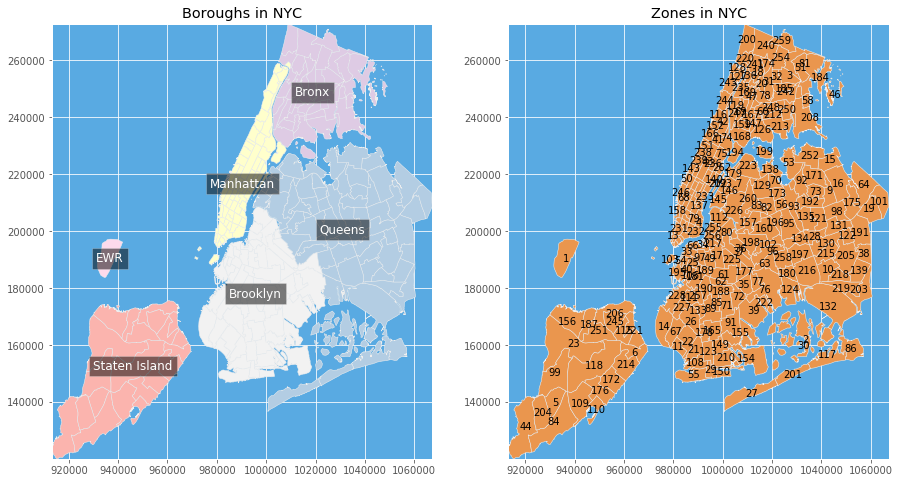

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs in NYC")
draw_region_map(ax, sf)
ax = plt.subplot(1, 2, 2)
ax.set_title("Zones in NYC")
draw_zone_map(ax, sf)

In [45]:
# Distribution of Passenger count during a trip
passenger_count = pd.read_sql_query('SELECT passenger_count AS Passenger, count(*) AS PCount FROM `nyc.2019-01` \
                        GROUP BY passenger_count', nyc_database)
passenger_count["Passenger"] = pd.factorize(passenger_count["Passenger"])[0]

passenger_count.iplot(x="Passenger", kind="bar", title="Distribution of Passenger count during a trip",
                      xTitle='Passenger count', yTitle='Count')

In [48]:
payment_type = pd.read_sql_query('SELECT payment_type AS ptype, count(*) AS Count FROM `nyc.2019-01` \
                        GROUP BY payment_type', nyc_database)
payment_type.iplot(x="ptype", kind="bar", title="Distribution of Payment type for a trip",
                      xTitle='Payment type', yTitle='Count')

In [49]:
df_pu = pd.read_sql_query('SELECT pickup_hour AS time, count(*) AS PUcount \
                        FROM `nyc.2019-01` \
                        GROUP BY pickup_hour', nyc_database)
df_do = pd.read_sql_query('SELECT dropoff_hour AS time, count(*) AS DOcount \
                        FROM `nyc.2019-01` \
                        GROUP BY dropoff_hour', nyc_database)
df_q2 = df_pu.merge(df_do, on="time")


df_q2.iplot(x="time", kind="scatter", mode='lines+markers', colors=['pink','blue'])